# Makemore reproduction

See the video by Andrej Karpathy about [Multilayer Perceptron](https://youtu.be/TCH_1BHY58I)

In [4]:
!pip install torch

In [57]:
!python --version

Python 3.7.4


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import csv

In [2]:
with open("names.txt") as f:
    words = [name[:-1] for name in  f.readlines()]

In [3]:
itos = ['.'] + [chr(c) for c in range(ord('a'), ord('z') + 1)]
stoi = {s:i for i, s in enumerate(itos)}

In [4]:
block_size = 4

def split(words):
    X, Y = [], []
    for w in words:
    #     print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
words_tr = words[:int(len(words) * 0.8)]
words_dev = words[int(len(words) * 0.8):int(len(words) * 0.9)]
words_test = words[int(len(words) * 0.9):]

Xtr, Ytr = split(words_tr)
Xdev, Ydev = split(words_dev)
Xtest, Ytest = split(words_test)

In [5]:
Xtr.shape, Xdev.shape, Xtest.shape

(torch.Size([182624, 4]), torch.Size([22655, 4]), torch.Size([22866, 4]))

In [6]:
import torch.nn.functional as F

In [36]:
embdim = 10
from_file = False
g = torch.Generator().manual_seed(2147483647)
if from_file:
    [C, W1, b1, W2, b2] = torch.load("parameters.pt")
else:
    C = torch.randn((27, embdim), generator=g)
    W1 = torch.randn((embdim * block_size, 300), generator=g) * 0.1
    b1 = torch.randn(300, generator=g) * 0.01
    W2 = torch.randn((300, 27), generator=g) * 0.01
    b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [37]:
sum(p.nelement() for p in parameters)

20697

In [38]:
lre = torch.linspace(-3, 0, 1000)
re = lre.exp()

In [39]:
hist = []

In [46]:
# lri = []
max_iter = 50_000
batch_size = 128
for i in range(max_iter):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], embdim * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    for p in parameters:
        p.grad = None
    loss.backward()
    hist.append(loss.item())
#     lr = re[i]
#     lri.append(lre[i])
    lr = 0.1 if i < max_iter - 100 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
#     break
print(loss.item())


1.8731669187545776


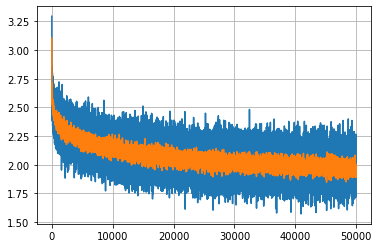

In [47]:
plt.plot(hist)
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
plt.plot(moving_average(hist))
plt.grid()

In [48]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, embdim * block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9454, grad_fn=<NllLossBackward0>)

(array([9493245., 2154230., 1485582., 1186914.,  981291.,  885265.,
         908119.,  753692.,  618544.,  619976.,  610841.,  538459.,
         534139.,  613800.,  449858.,  495107.,  530659.,  520982.,
         535232.,  406971.,  376542.,  507822.,  566703.,  505496.,
         489373.,  521135.,  481177.,  437345.,  417754.,  412834.,
         555728.,  524668.,  491740.,  443970.,  561636.,  591842.,
         508345.,  605346.,  592382.,  736080.,  731063.,  807696.,
         851390.,  834699.,  949293., 1109315., 1284030., 1506618.,
        2236780., 9825492.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <a list of 50 Patc

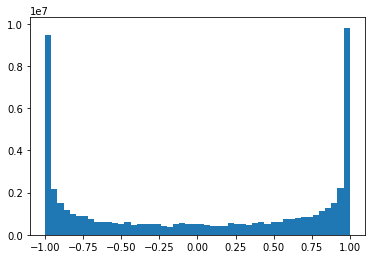

In [49]:
plt.hist(h.view(-1).tolist(), bins=50)

In [34]:
h.shape

torch.Size([182624, 300])

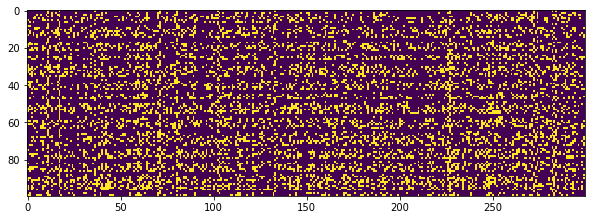

In [50]:
plt.figure(figsize=(10,5))
plt.imshow(h[:100, :].abs() > 0.99)

(array([1.430000e+02, 1.490000e+02, 2.610000e+02, 9.970000e+02,
        9.110000e+02, 1.659000e+03, 6.100000e+03, 7.735000e+03,
        1.723300e+04, 2.934900e+04, 5.286200e+04, 8.442400e+04,
        1.312270e+05, 2.218400e+05, 3.170770e+05, 4.908640e+05,
        6.794090e+05, 9.922490e+05, 1.472002e+06, 1.833123e+06,
        2.335430e+06, 2.987043e+06, 3.885697e+06, 4.857226e+06,
        5.862811e+06, 5.949710e+06, 5.554168e+06, 4.322398e+06,
        3.307575e+06, 2.577147e+06, 1.996640e+06, 1.452188e+06,
        1.091222e+06, 7.928520e+05, 5.272030e+05, 3.432410e+05,
        2.445630e+05, 1.449790e+05, 9.078900e+04, 5.915500e+04,
        3.108100e+04, 1.642400e+04, 1.101400e+04, 3.907000e+03,
        1.946000e+03, 6.670000e+02, 2.400000e+02, 2.150000e+02,
        4.800000e+01, 7.000000e+00]),
 array([-12.91962624, -12.4045043 , -11.88938236, -11.37426043,
        -10.85913849, -10.34401655,  -9.82889462,  -9.31377268,
         -8.79865074,  -8.2835288 ,  -7.76840687,  -7.25328493,
  

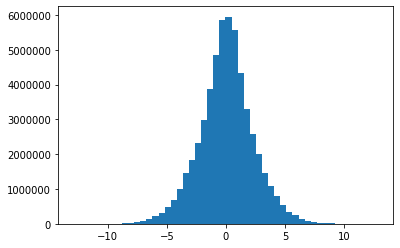

In [51]:
plt.hist((emb.view(-1, embdim * block_size) @ W1 + b1).view(-1).tolist(), bins=50)

In [52]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, embdim * block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0602, grad_fn=<NllLossBackward0>)

In [53]:
emb = C[Xtest]
h = torch.tanh(emb.view(-1, embdim * block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytest)
loss

tensor(2.0562, grad_fn=<NllLossBackward0>)

ValueError: x and y must have same first dimension, but have shapes (1000,) and (50000,)

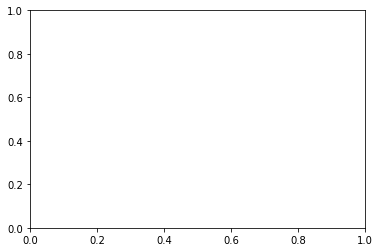

In [388]:
plt.plot(lri, hist, "-")

In [54]:
@torch.no_grad()
def gen_word():
    word = ""
    context = [0] * block_size
    for _ in range(10):
        emb = C[context]
#         print(f"{context} -> {emb}")
        h = torch.tanh(emb.view(embdim * block_size) @ W1 + b1)
        logits = h @ W2 + b2
#         print(logits.shape)
        probs = logits.exp()
#         print(probs)
        probs = probs / probs.sum()
#         print(probs)
        probsums = probs.cumsum(0)
        dice = torch.rand((1,), generator=g)
        for i, prob in enumerate(probsums):
            if dice < prob:
                nx = i
                break
        if nx == 0:
            break
        word += itos[nx]
#         ix = stoi[ch]
#         X.append(context)
#         Y.append(nx)
#         print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [nx]
    return word

In [56]:
for _ in range(20):
    print(gen_word())

omron
ayora
aamine
abdirkstor
braytna
simslyn
reya
lindine
lillany
zaeleigh
lyleen
maikorie
ferbell
vion
shlin
janell
keimunucur
savan
greckynlze
ermony


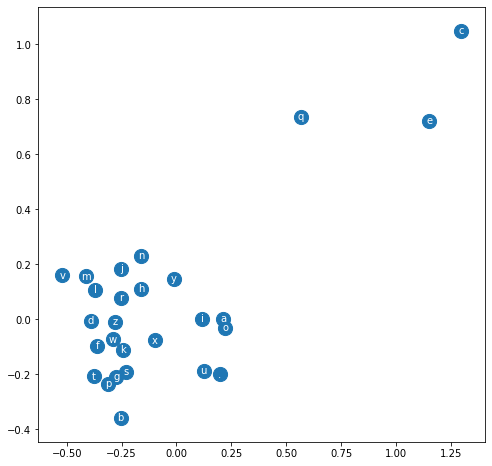

In [393]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), s=itos[i], ha="center", va="center", color="white")

In [457]:
torch.save(parameters, 'parameters.pt')